In [1]:
# default_exp fastai_adapter

In [2]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# export
import numpy as np
from PIL import Image 
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.layers import FlattenedLoss
from fastai.torch_core import *
from fastai.layers import MSELossFlat
from fastai.data_block import ItemList, FloatList
from fastai.vision import Image, ImageList
from deeptracktorch.simg import *

# Customizing the fastai ImageList class to serve up our sythentic images

## MImageList

Want to make use of fastai library for training the Neural Network. The library does a lot of the work of setting up and managing training and validations data sets and tracking inputs and labels.

The first thought is to have some code to generate image files. This would mean we could use the existing fastai ImageDataBunch class to read these files in from disk. This does work but generating image files seems a little unnecessary as we have everything we need to generate an image from the image parameters, meaning the images can be consistently generated on the fly. Not that this is faster than reading from the disk. But if we want to switch to a GPU enabled platform such as Google colab uploading files becomes a hassle.

So I sub-classed the ImageList class and FloatList class to generate images on the fly. Firstly, I overwrote the from_df helper method to take a dataframe containing the image parameters instead of image filenames. Secondly, I modified the get method to retrieve a set of parameters from the DataFrame and generate an synthetic microscopy image directly, rather than loading an image from disk.


In [45]:
#export

def MAELossFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    """Same as nn.L1Loss, but flattens input and target."""
    return FlattenedLoss(nn.L1Loss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

In [46]:
#export

def npimg2tensor(a):
    """Return the numpy array a, containing image data, as a torch tensor"""
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    return torch.from_numpy(a.astype(np.float32))
    
class MImageList(ImageList):
    "`ItemList` suitable for 'image specs' to ThreePoints (x, y, r) Tasks."
        
    def __init__(self, items:Iterator, **kwargs)->'MImageList':
        super().__init__(range_of(items), **kwargs) 
        # <-- the actual data, comes in through the **kwargs from_df class method
        # to ItemList where the data values are in inner_df, and items just becomes
        # a range of index values into that dataframe
        
    @classmethod
    def from_df(cls, df:pd.DataFrame, **kwargs)->'ItemList':
        df['img_data']=df.apply(lambda row: Image(npimg2tensor(generate_image(row))), axis=1)
        return cls(items=range(len(df)), inner_df=df.copy(), **kwargs)
    
    def get(self, i): 
        # generate sythenthetic image from specification stored in items
        res=self.inner_df.iloc[i]['img_data']
        self.sizes[i] = res.size
        return res 
    

class CustomSegmentationLabelList(MImageList):
    def open(self, i): return generate_mask(self.inner_df.iloc[i]) #after_open=self.after_open

class CustomSegmentationItemList(MImageList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = CustomSegmentationLabelList,False
    
    

## XYRItem and XYRList

For the labels (or the x,y,r triple target for the regression) I could've used a simple FloatList but in order to draw the dot on the images subclassed that with `XYRItem`, adding a `show()` method.

Note at the moment we are training against position in pixels, not -1 

In [47]:
# export 
class XYRItem(FloatItem):
    def show(self, ax:plt.Axes=None, figsize:Tuple=(3,3), title:Optional[str]=None, hide_axis:bool=True,
              cmap:str=None, y:Any=None, **kwargs):
        #xlim=ax.get_xlim(); ylim=ax.get_ylim()
        #hx=(xlim[1]-xlim[0])//2; hy=(ylim[0]-ylim[1])//2;
        ax.scatter(x=self.data[0],y=self.data[1],s=2,c=kwargs.get('marker_c','r'))
        ax.set_title(f'x={self.data[0]:.2f},y={self.data[1]:.2f},r={self.data[2]:.2f}')

class XYRList(ItemList):
    "`ItemList` suitable for storing the floats in items for regression. Will add a `log` if this flag is `True`."
    def __init__(self, items:Iterator, log:bool=False, classes:Collection=None, **kwargs):
        super().__init__(np.array(items, dtype=np.float32), **kwargs)
        self.log = log
        self.copy_new.append('log')
        self.c = self.items.shape[1] if len(self.items.shape) > 1 else 1
        self.loss_func = MAELossFlat()

    def get(self, i):
        o = super().get(i)
        return XYRItem(np.log(o) if self.log else o)

    def reconstruct(self,t): return XYRItem(t.numpy())
    

## Example of how to prepare a training dataset

This is how the functions and classes in this package can be used to generate a training dataset ready for use with fastai

In [48]:
from numpy.random import choice, normal, uniform, randint
from numpy import pi

In [49]:
img_dist = {   
    'n_particles': lambda: randint(0,5),
    'size': lambda: 51,
    'bkgd_level': lambda: uniform(0.2,0.8),
    'gradient_intensity': lambda: uniform(0,1),
    'gradient_direction': lambda: uniform(-pi,pi),
    'snr': lambda: uniform(10,100),
}

In [50]:
p_dist = {
    # the position of the particle relative to center of image. -1 to +1 being the edges in each direction.
    'x': lambda: np.clip(normal(0., 1),-1.1,1.1),
    'y': lambda: np.clip(normal(0., 1),-1.1,1.1),
    
    # I don't know what units this is in... pixels?
    'radius': lambda: uniform(1.5, 3),
    'intensities': lambda: [choice([-1, 1]) * uniform(.2, .6)],
    'bessel_orders': lambda: [randint(1, 3)],
    'ellip_direction': lambda: uniform(-pi, pi),
    'ellipticity':  lambda: uniform(1,1.1),
}

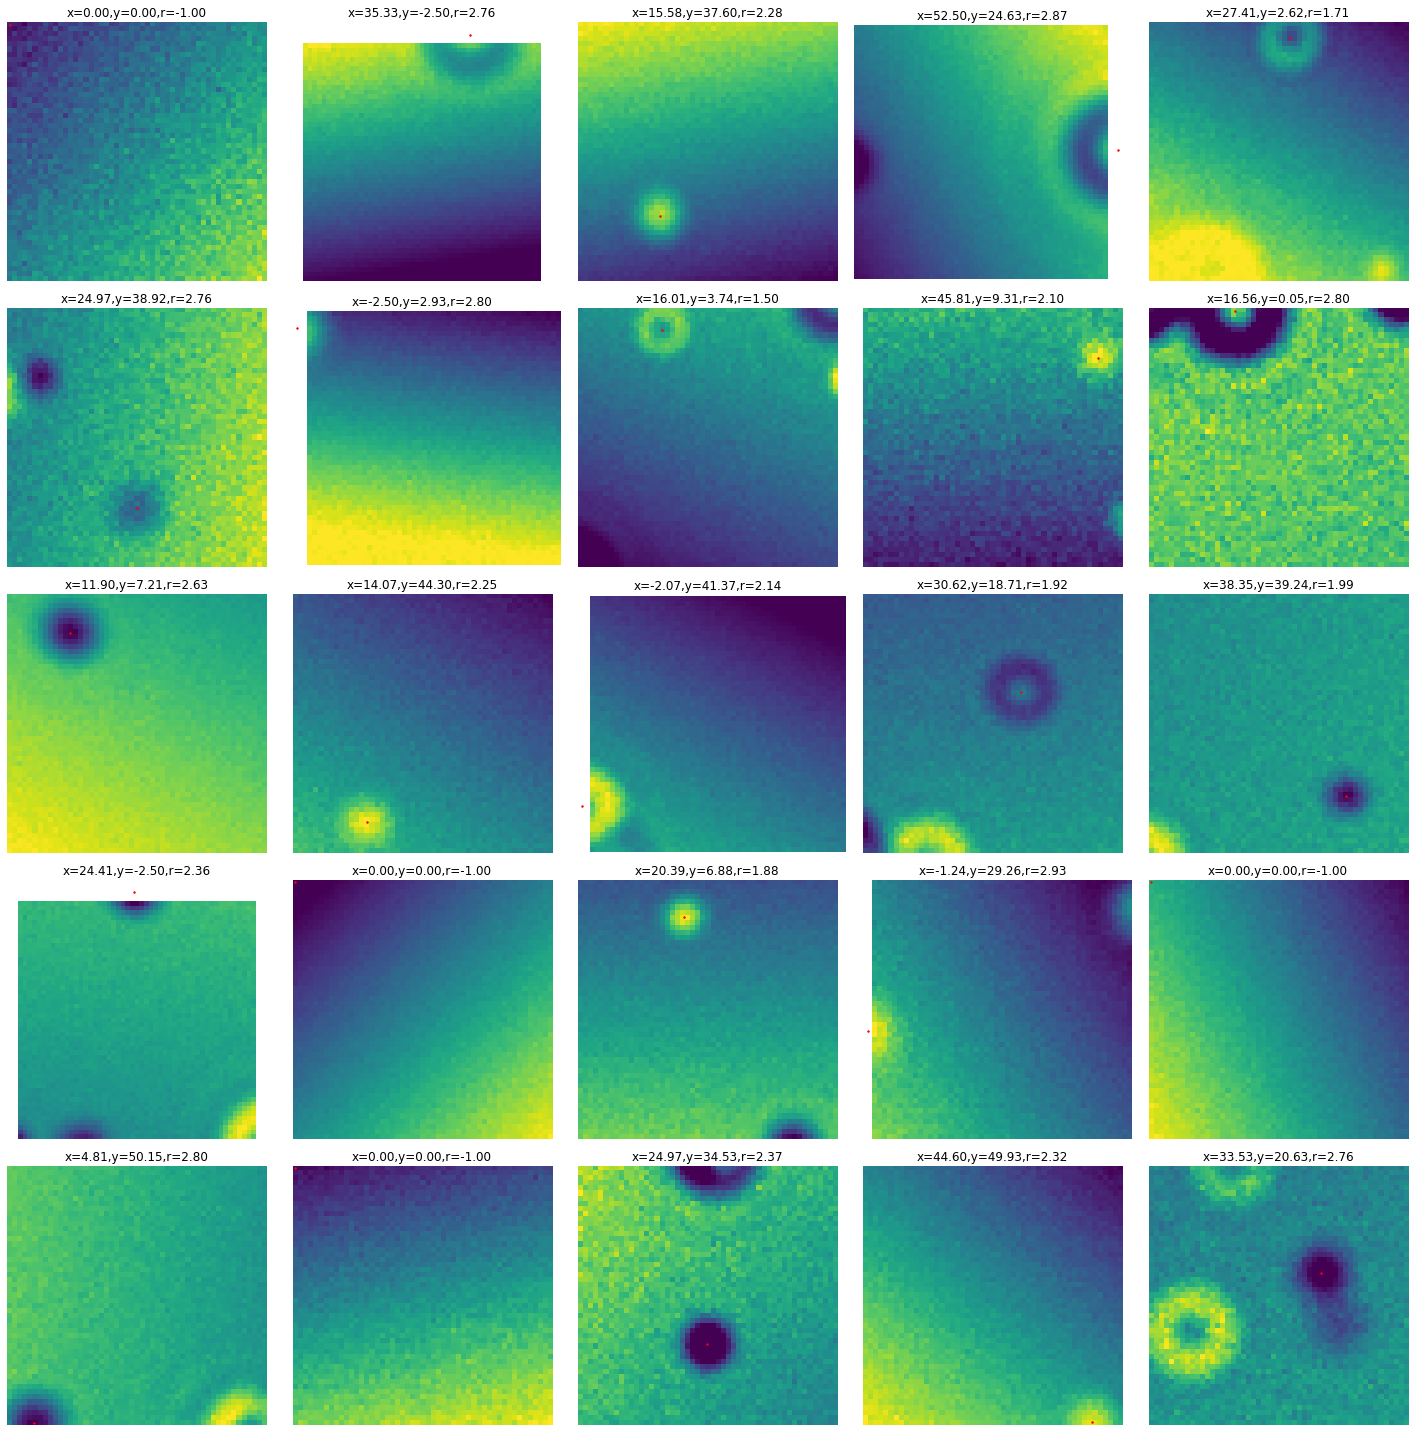

In [51]:
train_specs_df = define_image(img_dist, p_dist, 100)
train_specs_df = add_target(train_specs_df)
data=MImageList.from_df(train_specs_df).split_by_rand_pct(0.2).label_from_df(cols=['tx','ty','tr'],label_cls = XYRList).databunch(bs=32)
data.show_batch()

In [53]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_GenerateSyntheticImages.ipynb.
Converted 01_models.ipynb.
Converted 02_Video.ipynb.
Converted 03_Measures.ipynb.
Converted 04_fastai_adpater.ipynb.
Converted 98_Display.ipynb.
Converted 99_cli.ipynb.
Converted E1_Track1.ipynb.
Converted E1a_Track.ipynb.
Converted E2_Track1fromN.ipynb.
Converted E3_multipleparticles.ipynb.
Converted Untitled.ipynb.
Converted Untitled1.ipynb.
Converted index.ipynb.
Converted tutorial_CNN.ipynb.
